In [1]:
import os
from time import time
from matplotlib.pyplot import switch_backend
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize

In [6]:
def import_data(num_colony):
    path = "../dataset/tracking data/ant tracking data/Colony %i/Colony_%i_low_density_locations" % (num_colony, num_colony) #文件夹目录
    # get all the files in the folder
    files= os.listdir(path) 
    
    if ('.DS_Store' in files):
        files.remove('.DS_Store')

    index = 0
    return_matrix = []


    # iterator for traversing all the files
    for file in files: 
        # check if it is a file  
        if not os.path.isdir(file): 
            # open the file
            f = open(path+"/"+file) 
            df = pd.read_table(f, sep = ',') 
            data = df.values
            data = pd.DataFrame(data)

            data.columns = ['time', 'location_x', 'location_y', 'chamber']
            ant_id = np.ones((data.shape[0],1))*index
            colony_id = np.ones((data.shape[0],1))*num_colony
            ant_id = pd.DataFrame(ant_id, columns = ['ant_id'])
            colony_id = pd.DataFrame(colony_id, columns = ['colony_id'])
            data = pd.concat([data, ant_id], axis = 1)
            data = pd.concat([data, colony_id], axis = 1)

            if (index == 0):
                return_matrix = data
            else:
                return_matrix = pd.concat([return_matrix, data], axis = 0)
            index += 1
     
    return return_matrix


def minmax(data):    
    id = np.unique(data['chamber'])
    min = [[0]*(len(id)-1)for _ in range (2)]
    max = [[0]*(len(id)-1)for _ in range (2)]

    ant = data[(data['chamber']!=0)]
    for j in range (len(id)-1):
        a = ant[ant['chamber'] == j+1]
        max[0][j] = a['location_x'].max(axis=0)
        max[1][j] = a['location_y'].max(axis=0)
        min[0][j] = a['location_x'].min(axis=0)
        min[1][j] = a['location_y'].min(axis=0)
     
    return min, max


# transfer the unit from pixel in the picture to mm
def location_in_mm(data):

    df = data
    return_matrix = []
    min, max = minmax(data)

    for i in range(5):

        if (i == 0):
            return_matrix = df[df.chamber == i]

        else: 
            data = df[df.chamber == i]

            h_x = (max[0][i-1] - min[0][i-1])/65
            h_y = (max[1][i-1] - min[1][i-1])/40

            x = data['location_x']
            x = np.array(x)
            y = data['location_y']
            y = np.array(y)

            min_x = np.ones((len(x),))*min[0][i-1]
            min_y = np.ones((len(x),))*min[1][i-1]
            
            dif_y = np.ones((len(x),))*(i-1)*(40+6)

            x = np.round((x - min_x)/h_x, 2)
            y = np.round((y - min_y)/h_y+dif_y, 2)
            
            data['location_x'] = x
            data['location_y'] = y
    
            return_matrix = pd.concat([return_matrix, data], axis = 0)
    
    return_matrix = return_matrix.sort_index(axis = 0)
    return_matrix = tunnel(return_matrix)

    return return_matrix


# find the tunnel between the 4 chambers and put the ants 
# which are in chamber 0 into the chamber where it should be
def tunnel(data):

    zero_list = np.where(data['chamber'] == 0)

    while (len(zero_list[0])):


        a = zero_list[0][0]
        b = a + 1
        a = a - 1

        while (data.iloc[b, 3] == 0):
            b += 1

        for i in tqdm(range(a+1, b)):
            data.iloc[i, 3] = 5

        if (data.iloc[a, 4] == data.iloc[b, 4]):

            if (data.iloc[a, 3] != data.iloc[b, 3]):

                m = math.floor((data.iloc[a, 3] + data.iloc[b, 3])/2)

                for i in range(a+1, b):
                    data.iloc[i, 1] = 1
                    data.iloc[i, 2] = (40 + 6) * m - 3
                    data.iloc[i, 3] = m
            
            else:
                if ((data.iloc[a, 2] - 46 * (data.iloc[a, 3]-1) < 20) 
                & (data.iloc[b, 2] - 46 * (data.iloc[a, 3]-1) < 20)):
                    if (data.iloc[a, 3] != 1):
                        m = data.iloc[a, 3] - 1
                        for i in range(a+1, b):
                            data.iloc[i, 1] = 1
                            data.iloc[i, 2] = (40 + 6) * m - 3
                            data.iloc[i, 3] = m
                    else:
                        m = 1
                        for i in range(a+1, b):
                            data.iloc[i, 1] = 1
                            data.iloc[i, 2] = 0
                            data.iloc[i, 3] = m

                if ((data.iloc[a, 2] - 46 * (data.iloc[a, 3] - 1) > 20) 
                & (data.iloc[b, 2] - 46 * (data.iloc[a, 3] - 1) > 20)):
                    if (data.iloc[a, 3] != 4):
                        m = data.iloc[a, 3]
                        for i in range(a+1, b):
                            data.iloc[i, 1] = 1
                            data.iloc[i, 2] = (40 + 6) * m - 3
                            data.iloc[i, 3] = m
                    else:
                        m = 4
                        for i in range(a+1, b):
                            data.iloc[i, 1] = 1
                            data.iloc[i, 2] = 178
                            data.iloc[i, 3] = m


        zero_list = np.where(data['chamber'] == 0)

    return data



def time_series(data):

    time_list = pd.DataFrame(np.unique(data.time), columns = ['time'])
    index = np.arange(420)
    lab = np.zeros((len(time_list), 420))
    lab = pd.DataFrame(lab, columns = index)
    time_list = pd.concat([time_list, lab], axis = 1)
    
    for i in range(len(time_list)):
        for j in index:
            #print(data[(data['time'] == time_list.time[i]) & (data['label'] == j)].index.tolist())
            num = len(data[(data['time'] == time_list.time[i]) & (data['label'] == j)].index.tolist())
            
            time_list.iloc[i, j+1] = num
    '''
    for i in range(len(data)):
        ind = np.where(time_list['time'] == data.iloc[i, 0])       
        tmp = data.iloc[i, 6] + 1
        print(ind[0][0], tmp)
        time_list.iloc[int(ind[0][0]), int(tmp)] += 1
    '''
    return data, time_list


    
# step 1: import dataset 3 colonies 
def import_all_dataset():
    data = import_data(1)
    data = pd.concat([data, import_data(2)], axis = 0)
    data = pd.concat([data, import_data(3)], axis = 0)
    data.to_csv('../dataset/all_data.csv', index = False)
    return data



# step 2: discretisation of time, each 5 second
#data = pd.read_csv('../dataset/insect/ant/after_processing.csv')
#data = discretization_time(data)
#data.to_csv('../dataset/insect/ant/time_discretized.csv', index = False)
def discretization_time():
    data = pd.read_csv('../dataset/all_data.csv')
    data = data[(data.time == 1) | (data.time % 5 == 1)]
    data = data.reset_index(drop = True)
    data.to_csv('../dataset/time_discretized.csv', index = False)
    return data



# step 3: integration of coordinate
def integration_coordinate():
    data = pd.read_csv('../dataset/time_discretized.csv')
    data1 = []
    for i in range(1, 4):
        df = location_in_mm(data[data.colony_id == i])
        if (i == 1):
            data1 = df
        else:
            data1 = pd.concat([data1, df], axis = 0)
    data1
    data1.to_csv('../dataset/location_in_mm.csv', index = False)
    return data1



# step 4: plot distribution of ant
#data = pd.read_csv('../dataset/insect/ant/time_discretized.csv')
#ant_location(data)
def plot_ant_location():
    data = pd.read_csv('../dataset/location_in_mm.csv')
    col= np.unique(data['colony_id'])

    x = [0, 20, 40, 46, 66, 86, 92, 112, 132, 138, 158, 178]
    ymin = [0, 0, 5, 5, 0, 5, 5, 0, 5, 5, 0, 0]
    ymax = [65, 49, 65, 65, 49, 65, 65, 49, 65, 65, 49, 65]

    y = [65, 65, 65, 65,  0, 5, 5, 5]
    xmin = [0, 46, 92, 138,  0, 40, 86, 132]
    xmax = [40, 86, 132, 178, 178, 46, 92, 138]

    for i in range (len(col)):

        figsize(15,9)
        fig = plt.figure()

        ant = data[(data['colony_id'] == col[i])]
        plt.scatter(ant['location_y'], ant['location_x'], c = ant['ant_id'], cmap = 'jet', s=0.1)

        plt.vlines(x, ymin, ymax, color = 'black', lw = 2)
        plt.hlines(y, xmin, xmax, color = 'black', lw = 2)
        plt.title('location', fontsize = 24)
        plt.xlabel('y',fontsize = 16)
        plt.ylabel('x', fontsize = 16)

        plt.savefig("../figures/distribution_colony_%i" % (i+1))
        plt.show()



# step 5: discretisation of location, box of 5mm * 5mm
#data = pd.read_csv('../dataset/insect/ant/location_in_mm.csv')
#data = discretization_location(data)
#data.to_csv('../dataset/insect/ant/data_labelled.csv', index = False)
def discretization_location():
    data = pd.read_csv('../dataset/location_in_mm.csv')
    labels = np.zeros((len(data), 1))
    for i in range(len(data)):
        x = data.iloc[i, 1]
        y = data.iloc[i, 2]

        if (y <= 40):
            label = math.ceil(y/5) * math.ceil(x/5)
        else:
            if (y <= 46):
                label = 105
            else:
                if (y <= 86):
                    label = math.ceil((y-6)/5) * math.ceil(x/5) + 1
                else:
                    if (y <= 92):
                        label = 210
                    else: 
                        if (y <= 132):
                            label = math.ceil((y-12)/5) * math.ceil(x/5) + 2
                        else:
                            if (y <= 138):
                                label = 315
                            else:
                                label = math.ceil((y-18)/5) * math.ceil(x/5) + 3

        labels[i, 0] = label

    labels = pd.DataFrame(labels, columns = ['label'])
    data = pd.concat([data, labels], axis = 1)
    data.to_csv('../dataset/data_labelled.csv', index = False)
    return data



# step 6: time series of boxes
def time_series_boxes():
    data = pd.read_csv('../dataset/data_labelled.csv')
    data, time_list = time_series(data)
    time_list.to_csv('../dataset/time_series_boxes.csv', index = False)



# step 7: time series of chambers
def time_series_chambers():
    data = pd.read_csv('../dataset/location_in_mm.csv')

    time_list = pd.DataFrame(np.unique(data.time), columns = ['time'])

    k = 1
    for i in range(len(np.unique(data.colony_id))):
        for j in range(len(np.unique(data[data['colony_id'] == i+1]['ant_id']))):
            tmp = data[(data['colony_id'] == i+1) & (data['ant_id']== j)]['chamber']
            tmp.reset_index(drop = True, inplace = True)
            time_list = pd.concat([time_list, tmp], axis = 1)
            time_list.rename({'chamber':'%i'%k}, axis = 'columns', inplace = True)
            #print(time_list)
            k += 1

    print(time_list)
    time_list.to_csv('../dataset/time_series_chamber.csv', index = False)
    return time_list

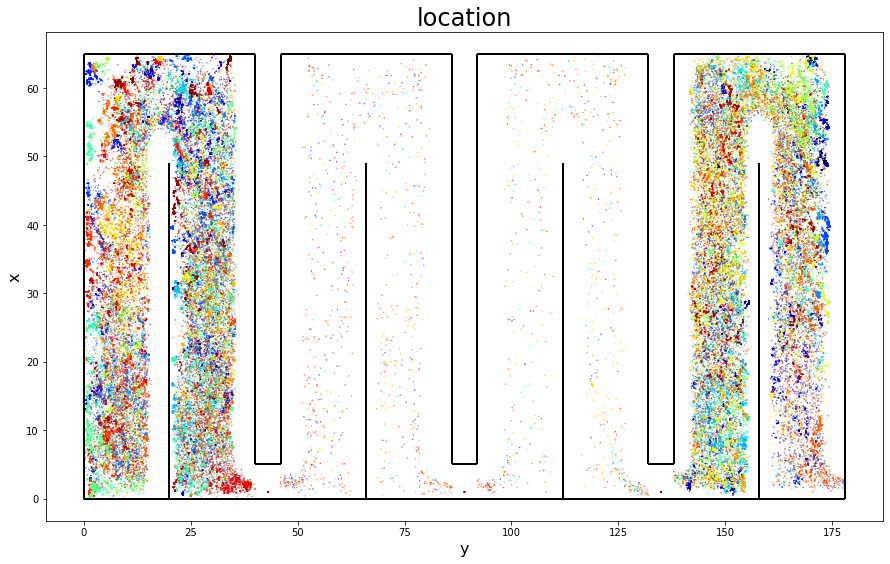

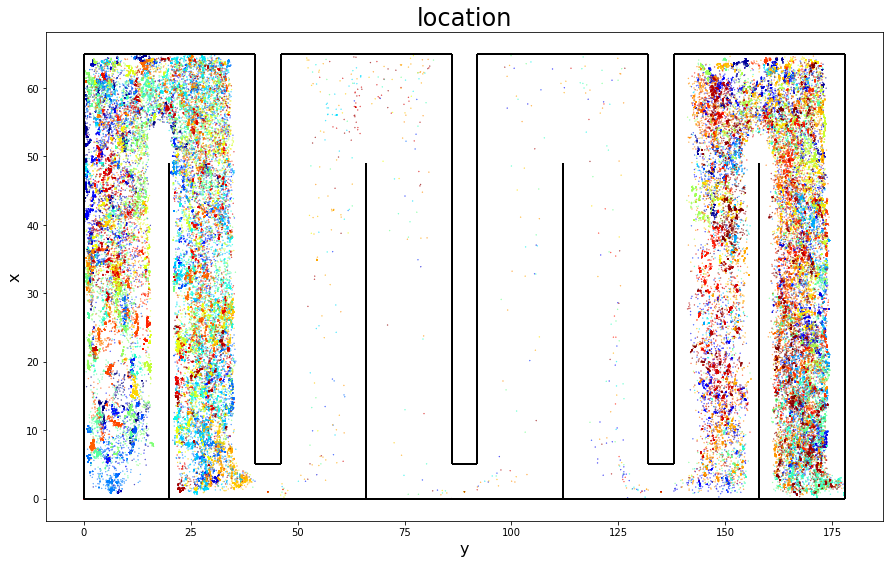

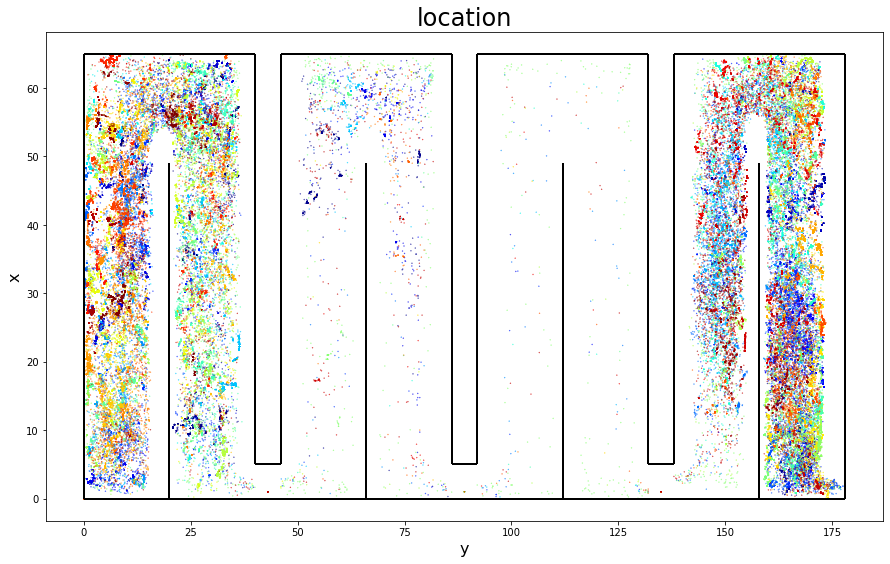

In [7]:
#import_all_dataset()
#discretization_time()
#integration_coordinate()
plot_ant_location()
#discretization_location()
#time_series_boxes()
#time_series_chambers()